In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-12 09:57:14.802679: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 09:57:14.862008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 09:57:16.197197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_preprocess.csv')
test = pd.read_csv('./data/test_preprocess.csv')

In [5]:
# pallet 변수 형태 지정하기
train['pallet'] = train['pallet'].astype('int64')
test['pallet'] = test['pallet'].astype('int64')

In [6]:
# target값을 숫자로 바꾸기
train['target_num'] = np.where(train['target'] == 'Normal', 1, -1)

In [7]:
train['target'].value_counts()

target
Normal      38156
AbNormal     2350
Name: count, dtype: int64

In [8]:
# sklearn의 OneHotEncoder를 이용한 원핫인코딩
encoder = OneHotEncoder(drop = 'first')
X = encoder.fit_transform(train[['model_suffix']])
train[encoder.get_feature_names_out()] = pd.DataFrame(X.toarray(), columns=encoder.get_feature_names_out())

X_test = encoder.transform(test[['model_suffix']])
test[encoder.get_feature_names_out()] = pd.DataFrame(X_test.toarray(), columns=encoder.get_feature_names_out())

In [9]:
# index 
train_index = train[train['target'] == 'Normal'].sample(38156-2350, random_state = 42).index

In [10]:
# one class train, valid split
df_train = train[train.index.isin(train_index)]
df_valid = train[~train.index.isin(train_index)]

In [11]:
# 각 영역별 사용할 변수 지정
dam = ['target_num', 'inconsistant', 'dam_cure_position',
      'cure_speed_dam', 'discharged_speed_dam', 'cid_time_dam', 'seq_time_dam',
       'cluster_time_dam', 'cid_volume_dam', 'Seq_volume_dam',
       'cluster_volume_dam', 'distance_diff_cid_seq_dam',
       'distance_diff_seq_cluster_dam', 'dam_time',
       'Stage1 Circle1 Distance Speed Collect Result_Dam',
       'Stage1 Circle2 Distance Speed Collect Result_Dam',
       'Stage1 Circle3 Distance Speed Collect Result_Dam',
       'Stage1 Circle4 Distance Speed Collect Result_Dam',
       'Stage1 Line1 Distance Speed Collect Result_Dam',
       'Stage1 Line2 Distance Speed Collect Result_Dam',
       'Stage1 Line3 Distance Speed Collect Result_Dam',
       'Stage1 Line4 Distance Speed Collect Result_Dam',
       'Stage2 Circle1 Distance Speed Collect Result_Dam',
       'Stage2 Circle2 Distance Speed Collect Result_Dam',
       'Stage2 Circle3 Distance Speed Collect Result_Dam',
       'Stage2 Circle4 Distance Speed Collect Result_Dam',
       'Stage2 Line1 Distance Speed Collect Result_Dam',
       'Stage2 Line2 Distance Speed Collect Result_Dam',
       'Stage2 Line3 Distance Speed Collect Result_Dam',
       'Stage2 Line4 Distance Speed Collect Result_Dam',
       'Stage3 Circle1 Distance Speed Collect Result_Dam',
       'Stage3 Circle2 Distance Speed Collect Result_Dam',
       'Stage3 Circle3 Distance Speed Collect Result_Dam',
       'Stage3 Circle4 Distance Speed Collect Result_Dam',
       'Stage3 Line1 Distance Speed Collect Result_Dam',
       'Stage3 Line2 Distance Speed Collect Result_Dam',
       'Stage3 Line3 Distance Speed Collect Result_Dam',
       'Stage3 Line4 Distance Speed Collect Result_Dam', 'thickness_set'] + list(encoder.get_feature_names_out())
fill1 = ['target_num', 'inconsistant', 'dam_cure_position',
        'discharged_speed_fill1',
       'cid_time_fill1', 'seq_time_fill1', 'cluster_time_fill1',
       'cid_volume_fill1', 'Seq_volume_fill1', 'cluster_volume_fill1',
       'distance_diff_cid_seq_fill1', 'distance_diff_seq_cluster_fill1',
       'fill1_time'
        ] + list(encoder.get_feature_names_out())
fill2 = [
    'target_num', 'inconsistant', 'dam_cure_position',
         'distance_diff_cid_seq_fill2', 'distance_diff_seq_cluster_fill2',
         'fill2_cure_position', 'fill2_time'
] + list(encoder.get_feature_names_out())
autoclave = ['target_num', 'inconsistant', 'dam_cure_position',
            '1st Pressure Collect Result_AutoClave',
           '2nd Pressure Collect Result_AutoClave',
           '3rd Pressure Collect Result_AutoClave',
           'Chamber Temp. Collect Result_AutoClave', 'autoclave_time'
            ] + list(encoder.get_feature_names_out())

df_train_dam = df_train[dam]
df_train_fill1 = df_train[fill1]
df_train_fill2 = df_train[fill2]
df_train_autoclave = df_train[autoclave]

df_valid_dam = df_valid[dam]
df_valid_fill1 = df_valid[fill1]
df_valid_fill2 = df_valid[fill2]
df_valid_autoclave = df_valid[autoclave]

## Dam

In [12]:
# train, valid 
Xt_dam = df_train_dam[df_train_dam.columns.difference(['target_num'])]

Xv_dam = df_valid_dam[df_valid_dam.columns.difference(['target_num'])]
yv_dam = df_valid_dam['target_num']

In [13]:
# IsolationForest 모델 만들기
isol_dam = IsolationForest(max_samples=100, random_state = 42) 

# 만들어 둔 데이터셋에 알고리즘 피팅시키기
isol_dam.fit(Xt_dam)

# 예측해보기
y_pred_vaild_dam = isol_dam.predict(Xv_dam)

In [14]:
get_clf_eval(yv_dam, y_pred_vaild_dam)

오차행렬:
 [[1464  886]
 [1366  984]]

정확도: 0.5209
정밀도: 0.5262
재현율: 0.4187
F1: 0.4664


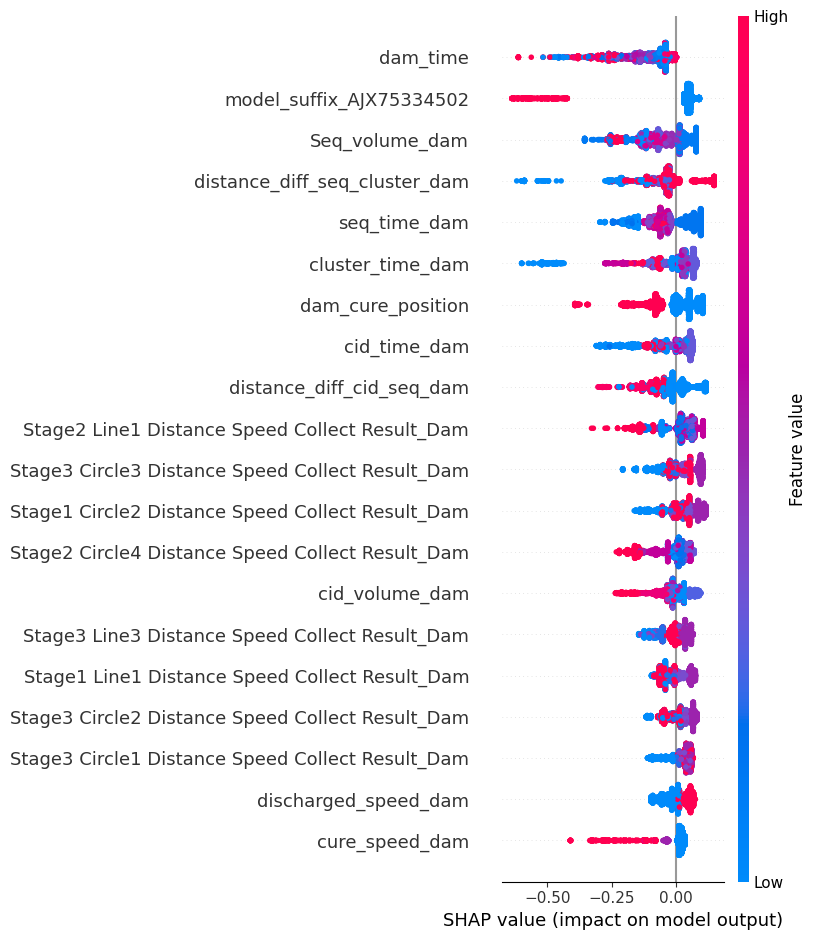

In [15]:
import shap
explainer = shap.Explainer(isol_dam)
shap_values = explainer(Xv_dam)
shap.initjs()

shap.summary_plot(shap_values, Xv_dam)

## Fill1

In [16]:
# train, valid 
Xt_fill1 = df_train_fill1[df_train_fill1.columns.difference(['target_num'])]

Xv_fill1 = df_valid_fill1[df_valid_fill1.columns.difference(['target_num'])]
yv_fill1 = df_valid_fill1['target_num']

In [17]:
# IsolationForest 모델 만들기
isol_fill1 = IsolationForest(max_samples=100, random_state = 42) 

# 만들어 둔 데이터셋에 알고리즘 피팅시키기
isol_fill1.fit(Xt_fill1)

# 예측해보기
y_pred_vaild_fill1 = isol_fill1.predict(Xv_fill1)

In [18]:
get_clf_eval(yv_fill1, y_pred_vaild_fill1)

오차행렬:
 [[ 849 1501]
 [ 550 1800]]

정확도: 0.5636
정밀도: 0.5453
재현율: 0.7660
F1: 0.6371


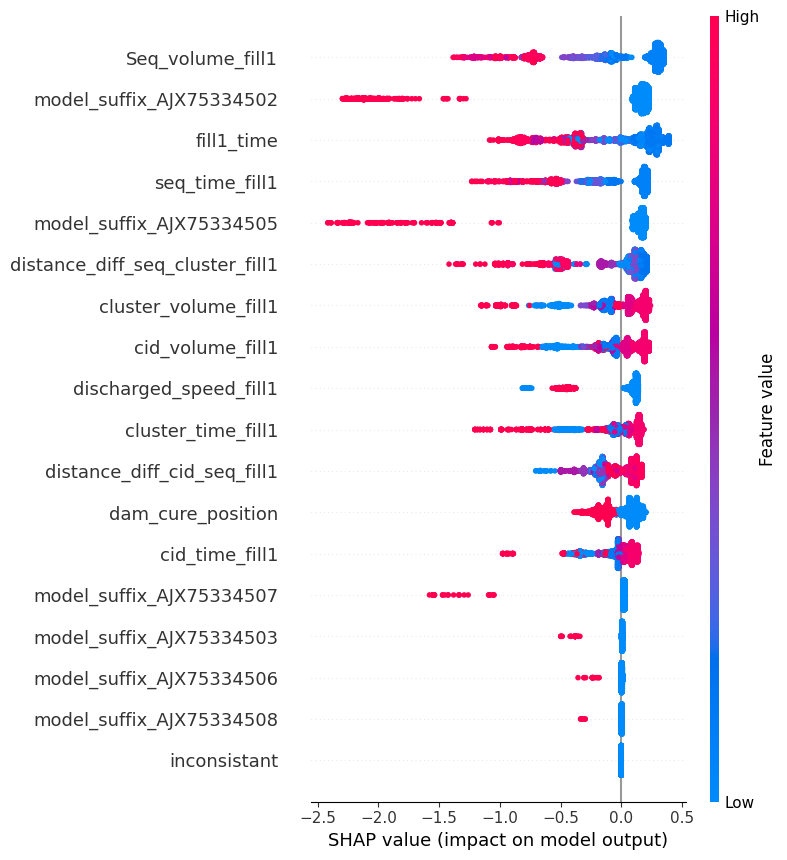

In [19]:
explainer = shap.Explainer(isol_fill1)
shap_values = explainer(Xv_fill1)
shap.initjs()

shap.summary_plot(shap_values, Xv_fill1)

## Fill2

In [20]:
# train, valid 
Xt_fill2 = df_train_fill2[df_train_fill2.columns.difference(['target_num'])]

Xv_fill2 = df_valid_fill2[df_valid_fill2.columns.difference(['target_num'])]
yv_fill2 = df_valid_fill2['target_num']

In [21]:
# IsolationForest 모델 만들기
isol_fill2 = IsolationForest(max_samples=100, random_state = 42) 

# 만들어 둔 데이터셋에 알고리즘 피팅시키기
isol_fill2.fit(Xt_fill2)

# 예측해보기
y_pred_vaild_fill2 = isol_fill2.predict(Xv_fill2)

In [22]:
get_clf_eval(yv_fill2, y_pred_vaild_fill2)

오차행렬:
 [[ 827 1523]
 [ 744 1606]]

정확도: 0.5177
정밀도: 0.5133
재현율: 0.6834
F1: 0.5862


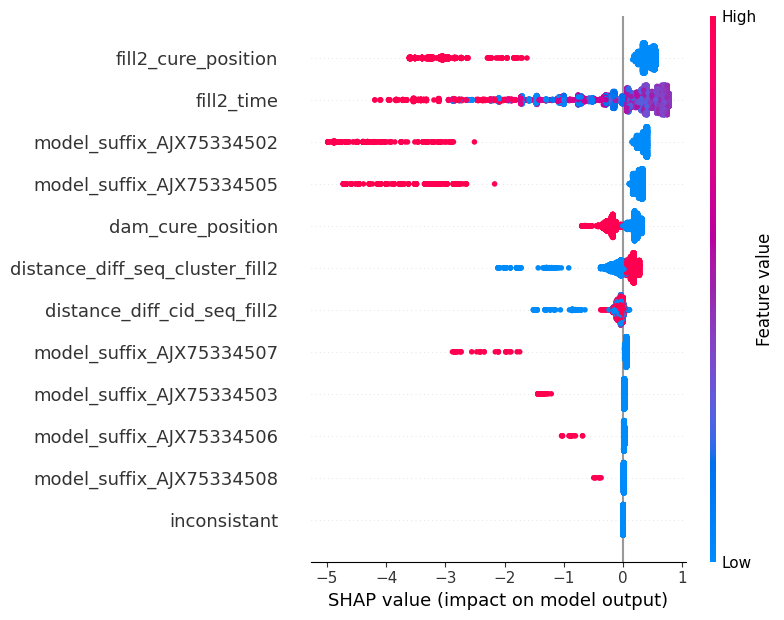

In [23]:
explainer = shap.Explainer(isol_fill2)
shap_values = explainer(Xv_fill2)
shap.initjs()

shap.summary_plot(shap_values, Xv_fill2)

## Autoclave

In [24]:
# train, valid 
Xt_autoclave = df_train_autoclave[df_train_autoclave.columns.difference(['target_num'])]

Xv_autoclave = df_valid_autoclave[df_valid_autoclave.columns.difference(['target_num'])]
yv_autoclave = df_valid_autoclave['target_num']

In [25]:
# IsolationForest 모델 만들기
isol_autoclave = IsolationForest(max_samples=100, random_state = 42) 

# 만들어 둔 데이터셋에 알고리즘 피팅시키기
isol_autoclave.fit(Xt_autoclave)

# 예측해보기
y_pred_vaild_autoclave = isol_autoclave.predict(Xv_autoclave)

In [26]:
np.unique(yv_autoclave, return_counts = True)

(array([-1,  1]), array([2350, 2350]))

In [27]:
np.unique(y_pred_vaild_autoclave, return_counts = True)

(array([-1,  1]), array([1140, 3560]))

In [28]:
get_clf_eval(yv_autoclave, y_pred_vaild_autoclave)

오차행렬:
 [[ 598 1752]
 [ 542 1808]]

정확도: 0.5119
정밀도: 0.5079
재현율: 0.7694
F1: 0.6118


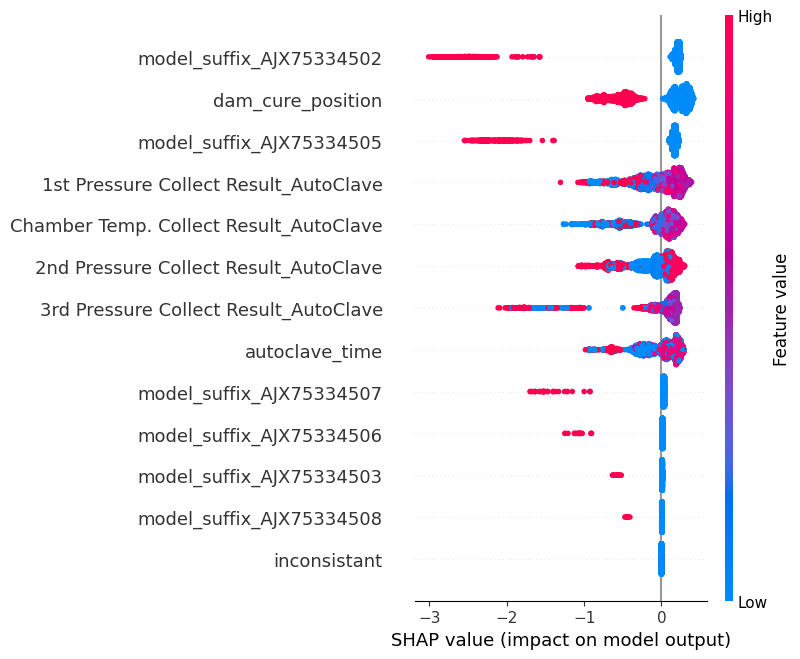

In [29]:
explainer = shap.Explainer(isol_autoclave)
shap_values = explainer(Xv_autoclave)
shap.initjs()

shap.summary_plot(shap_values, Xv_autoclave)

# 민감성

In [30]:
test_dam_x = test[Xt_dam.columns]
test_fill1_x = test[Xt_fill1.columns]
test_fill2_x = test[Xt_fill2.columns]
test_AutoClave_x = test[Xt_autoclave.columns]

In [31]:
dam_test_pred = isol_dam.predict(test_dam_x)
dam_test_pred

array([-1, -1,  1, ...,  1, -1, -1])

In [32]:
fill1_test_pred = isol_fill1.predict(test_fill1_x)
fill1_test_pred

array([ 1,  1,  1, ...,  1, -1,  1])

In [33]:
fill2_test_pred = isol_fill2.predict(test_fill2_x)
fill2_test_pred

array([ 1,  1, -1, ...,  1, -1,  1])

In [34]:
AutoClave_test_pred = isol_autoclave.predict(test_AutoClave_x)
AutoClave_test_pred

array([ 1, -1,  1, ...,  1,  1,  1])

In [35]:
result = np.where(
    (dam_test_pred == 1) & (fill1_test_pred) & (fill2_test_pred) & (AutoClave_test_pred) == 1, 'Normal', 'AbNormal'
)

In [36]:
np.unique(result, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([10207,  7154]))

In [37]:
test['target'] = result

In [38]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,10190,7143
1,17,11


In [39]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = result

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)